In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

# Load the MNIST dataset

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist)

# Take a quick look at one digit in the dataset

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
some_digit = X[36000]

In [8]:
some_digit_image = some_digit.reshape(28,28)

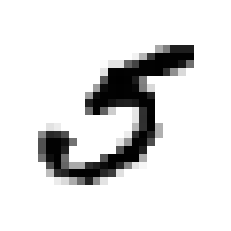

In [9]:
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


# Split the data into train and test

In [10]:
test_split = 60000
X_train, X_test, y_train, y_test = X[:test_split], X[test_split:], y[:test_split], y[test_split:]

# Shuffle the training 

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Try the kNeighborsClassifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score

In [13]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
knn_clf.predict([some_digit])

array([5], dtype=int8)

# Evaluate default kNeighborsClassifier

In [15]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.96960608, 0.96739837, 0.96884533])

# Use a grid search to improve result of kNeighborsClassifier
search on the weights and n_neighbors parameters

In [14]:
knn_clf = KNeighborsClassifier()

param_grid = [{ 
    'weights': ['uniform', 'distance'],
    'n_neighbors': [5,10,20]
}]

grid_search = GridSearchCV(knn_clf, param_grid=param_grid, scoring=')

grid_search.fit(X_train, y_train)

/anaconda2/envs/handson/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': [5, 10, 20],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [19]:
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [20]:
grid_search.best_score_

0.9697833333333333

In [21]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [ ]:
param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

/anaconda2/envs/handson/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


# Write function to shift images by one pixel in any direction
Use the shift() function from the scipy.ndimage.interpolation module.

In [13]:
from scipy.ndimage.interpolation import shift

def shift_image(img, direction='N'):
    shift_vec = [0,0]
    if direction == 'N':
        shift_vec = [-1,0]
    elif direction == 'S':
        shift_vec = [1,0]
    elif direction == 'E':
        shift_vec = [0,1]
    elif direction == 'W':
        shift_vec = [0,-1]    
    
    if img.ndim == 1:
        img = img.reshape(28,28)

    img = shift(img, shift_vec, cval=0)

    return np.around(img.reshape(28*28))
  

In [15]:
X_train_shift = X_train.copy()
y_train_shift = y_train.copy()

for direction in ['N', 'E', 'S', 'W']:
    X_train_shift = np.concatenate((
        X_train_shift, 
        np.apply_along_axis(shift_image, 1, X_train, direction
                           )
    ))
    y_train_shift = np.concatenate((y_train_shift, y_train))

In [17]:
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train_shift, y_train_shift)
y_kkn_pred = knn_clf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_test, y_kkn_pred)

0.9763